In [ ]:
# imports & stuff
import os
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = ''
 
from os.path import join as pjoin
import glob
import numpy as np
import cv2
import matplotlib as mpl
from matplotlib import pyplot as plt
mpl.rcParams["figure.figsize"] = (20, 20)
%matplotlib inline
%load_ext autoreload
%autoreload 2
    
from utils import *

ROOT_DIR = os.getcwd()
print(ROOT_DIR)
 
DATA_DIR = pjoin(ROOT_DIR, 'data')
print(DATA_DIR)

In [31]:
# Get data
img_files = {}
mask_files = {}
cover_files = {}

img_files['all'] = sorted(glob.glob(pjoin(DATA_DIR, 'OverviewBF*.png')))
mask_files['all'] = sorted(glob.glob(pjoin(DATA_DIR, 'SampleMask*.png')))
cover_files['all'] = sorted(glob.glob(pjoin(DATA_DIR, 'CoverslipMask*.png')))

train_ids = [580, 8, 4, 1, 39, 9, 12, 17, 2, 617, 568, 588, 159, 20, 13, 750, 3, 14, 22, 567, 10, 7, 21, 15, 11, 566,6]
val_ids = [18, 749, 16, 19, 519, 379, 5, 248]

img_files['train'] = [file for file in img_files['all'] if int(file[-8:-5]) in train_ids]
mask_files['train'] = [file for file in mask_files['all'] if int(file[-8:-5]) in train_ids]
cover_files['train'] = [file for file in cover_files['all'] if int(file[-8:-5]) in train_ids]

img_files['val'] = [file for file in img_files['all'] if int(file[-8:-5]) in val_ids]
mask_files['val'] = [file for file in mask_files['all'] if int(file[-8:-5]) in val_ids]
cover_files['val'] = [file for file in cover_files['all'] if int(file[-8:-5]) in val_ids]

TRAIN_SIZE = len(img_files['train'])
VAL_SIZE = len(img_files['val'])

### Raw images

In [32]:
# # Visualize data
# mpl.rcParams["figure.figsize"] = (15, 15)
# NUM_SAMPLES = len(img_files)

# for data_mode in ['train', 'val']:
#     print('{} SET:'.format(data_mode.upper()))
#     for i, (img_file, mask_file, cover_file) in \
#                 enumerate(zip(img_files[data_mode],
#                               mask_files[data_mode],
#                               cover_files[data_mode])):
#         img = imread(img_file)
#         mask = imread(mask_file)
#         box = imread(cover_file)
#         plt.subplot(1, 5, 1)
#         imshow(img, i)
#         plt.subplot(1, 5, 2)
#         maskshow(box)
#         plt.subplot(1, 5, 3)
#         imshow(img*box)
#         plt.subplot(1, 5, 4)
#         maskshow(mask)
#         plt.subplot(1, 5, 5)
#         imshow(img*mask)
#         plt.show()

### Preprocessed (cropped to cover-slip) images & masks -- save them and use further

In [ ]:
mpl.rcParams["figure.figsize"] = (10, 10)
PAD_SIZE = (0, 0)

covers_path = pjoin(DATA_DIR, 'covers')
if not os.path.exists(covers_path):
    os.mkdir(covers_path)

Img_files = {}
Mask_files = {}
for data_mode in ['train', 'val']:
    print('{} SET:'.format(data_mode.upper()))
    Img_files[data_mode] = []
    Mask_files[data_mode] = []
    
    for i, (img_file, cover_file, mask_file) in \
                enumerate(zip(img_files[data_mode],
                              cover_files[data_mode],
                              mask_files[data_mode])):

        img = imread(img_file)
        cover = imread(cover_file)
        mask = imread(mask_file)
        
        new_img = get_cover(img, cover, PAD_SIZE)
        new_mask = get_cover(mask, cover, PAD_SIZE)
        new_mask[new_mask>1] = 1
        
        Img_file = pjoin(covers_path, 'IMG{}'.format(cover_file[-10:]))
        Mask_file = pjoin(covers_path, 'MASK{}'.format(cover_file[-10:]))
#         imsave(Img_file, new_img)
#         imsave(Mask_file, new_mask)
        Img_files[data_mode].append(Img_file)
        Mask_files[data_mode].append(Mask_file)
        
    print('\n'.join(Img_files[data_mode]))
    print('\n'.join(Mask_files[data_mode]))

#### Check cover-slipped

In [ ]:
# Visualize data
mpl.rcParams["figure.figsize"] = (20, 20)
NUM_SAMPLES = len(img_files)

for data_mode in ['train', 'val']:
    print('{} SET:'.format(data_mode.upper()))
    for i, (img_file, mask_file) in \
                enumerate(zip(Img_files[data_mode],
                              Mask_files[data_mode])):
        img = imread(img_file)
        mask = imread(mask_file)

        plt.subplot(1, 5, 1)
        imshow(img, i)
        plt.subplot(1, 5, 2)
        maskshow(mask)
        plt.subplot(1, 5, 3)
        imshow(img*mask)
        plt.show()

### Generate patches

In [348]:
import matplotlib.pyplot as plt
import scipy.stats as stats

lower, upper = 3.5, 6
mu, sigma = 5, 0.7
X = stats.truncnorm(
    (lower - mu) / sigma, (upper - mu) / sigma, loc=mu, scale=sigma)
N = stats.norm(loc=mu, scale=sigma)

# fig, ax = plt.subplots(2, sharex=True)
# ax[0].hist(X.rvs(10000), normed=True)
# ax[1].hist(N.rvs(10000), normed=True)
# plt.show()

In [349]:
num_patches = 10
(h, w) = (10, 10)
(H, W) = (100, 100)

lower, upper = 0, H - h - 1
mu = (H - h - 1) // 2
sigma = mu // 2
y1s = stats.truncnorm((lower - mu) / sigma, (upper - mu) / sigma, loc=mu, scale=sigma).rvs(num_patches)

lower, upper = 0, W - w - 1
mu = (W - w - 1) // 2
sigma = mu // 2
x1s = stats.truncnorm((lower - mu) / sigma, (upper - mu) / sigma, loc=mu, scale=sigma).rvs(num_patches)

# x1s = np.random.normal(size=num_patches)
# y1s = np.random.normal(size=num_patches)

In [ ]:
mpl.rcParams["figure.figsize"] = (8, 8)
PATCH_SIZE = (64, 64)


# i = 1
for data_mode in ['train', 'val']:
    print('{} SET:'.format(data_mode.upper()))
    for img_file, mask_file in zip(Img_files[data_mode],
                                   Mask_files[data_mode]):
        img = imread(img_file)

        plt.subplot(1, 2, 1)
        imshow(img)
        cross_points, patches = get_patches(img, PATCH_SIZE)
        plt.subplot(1, 2, 2)
        draw_grid(img, cross_points, 'lines')
        plt.show()

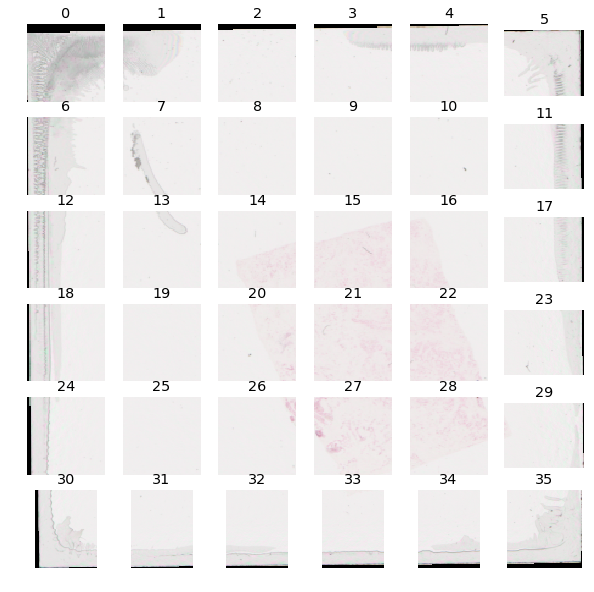

In [354]:
# Visualize patches
mpl.rcParams["figure.figsize"] = (10, 10)
i = 6
img = imread(Img_files['train'][i])
cross_points, patches = get_patches(img, PATCH_SIZE)

th, tw = cross_points.shape[:2]
for i in range(len(patches)):
    plt.subplot(th-1, tw-1, i+1)
    imshow(patches[i], i)
plt.show()

### Exploring class balance

TRAIN SET:


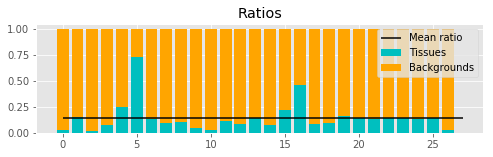

The mean ratio of classes: 14.75% tissues
VAL SET:


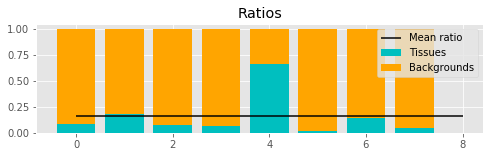

The mean ratio of classes: 15.95% tissues


In [368]:
# Visuzlize classes balance
plt.style.use('ggplot')
mpl.rcParams["figure.figsize"] = (8, 2)
total_tissues = []
total_backgrounds = []

for data_mode in ['train', 'val']:
    print('{} SET:'.format(data_mode.upper()))
    tissues = []
    backgrounds = []
    for img_file, mask_file in zip(Img_files[data_mode],
                                   Mask_files[data_mode]):
        img = imread(img_file)
        mask = imread(mask_file)
        t = np.unique(mask)
        tissues.append(mask.sum())
        backgrounds.append(mask.size)
    tissues = np.array(tissues)
    backgrounds = np.array(backgrounds)
    masks_ratios = tissues / backgrounds
    plot_ratio(masks_ratios)
    plt.show()
    print('The mean ratio of classes: {}% tissues'.format(np.round(masks_ratios.mean() * 100, 2)))
    print()
    total_tissues.extend(tissues)
    total_backgrounds.extend(backgrounds)
    
total_tissues = np.array(total_tissues)
total_backgrounds = np.array(total_backgrounds)

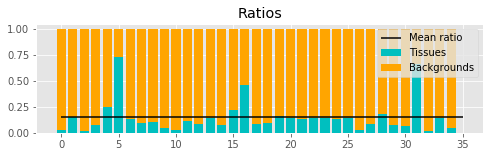

The mean ratio of classes: 15.02% tissues


In [369]:
masks_ratios = total_tissues / total_backgrounds
plot_ratio(masks_ratios)
plt.show()
print('The mean ratio of classes: {}% tissues'.format(np.round(masks_ratios.mean() * 100, 2)))

### Augmentations

In [84]:
# import imgaug as ia
# from imgaug import augmenters as iaa
# sometimes = lambda aug: iaa.Sometimes(0.5, aug)
# seq = iaa.OneOf(
#             [
#                 iaa.Fliplr(0.5), # horizontally flip 50% of all images
#                 iaa.Flipud(0.5), # vertically flip 20% of all images
#                 iaa.CropAndPad(
#                     percent=(-0.05, 0.1),
#                     pad_mode='edge',
#                     pad_cval=(0, 255)
#                 ),
#                 iaa.Affine(
#                     scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}, # scale images to 80-120% of their size, individually per axis
#                     translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}, # translate by -20 to +20 percent (per axis)
#                     rotate=(-45, 45), # rotate by -45 to +45 degrees
#                     shear=(-16, 16), # shear by -16 to +16 degrees
#                     order=[0, 1], # use nearest neighbour or bilinear interpolation (fast)
#                     cval=(0, 255), # if mode is constant, use a cval between 0 and 255
#                     mode='edge' # use zeros for padding
#                 ),
                
#                 iaa.GaussianBlur((0, 1.5)), # blur images with a sigma between 0 and 1.5
#                 iaa.AverageBlur(k=(2, 4)), # blur image using local means with kernel sizes between 2 and 7
#                 iaa.MedianBlur(k=(3, 5)), # blur image using local medians with kernel sizes between 3 and 5
                
#                 iaa.Sharpen(alpha=(0, 0.5), lightness=(0.75, 1.5)), # sharpen images
#                 iaa.Emboss(alpha=(0, 0.5), strength=(0, 0.5)), # emboss images
                
#                 iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.03*255), per_channel=0.5), # add gaussian noise to images
#                 iaa.Dropout((0, 0.02), per_channel=0.5), # randomly remove up to 10% of the pixels
#                 #iaa.CoarseDropout((0.03, 0.15), size_percent=(0.02, 0.05), per_channel=0.2),
#                 iaa.Add((-10, 10), per_channel=0.5), # change brightness of images (by -10 to 10 of original value)
#                 iaa.AddToHueAndSaturation((-20, 20)), # change hue and saturation
#                 iaa.Multiply((0.7, 1.2), per_channel=0.01),
#                 iaa.FrequencyNoiseAlpha(
#                     exponent=(-4, 0),
#                     first=iaa.Multiply((0.7, 1.3), per_channel=False),
#                     second=iaa.ContrastNormalization((0.7, 1.5))),
#                 iaa.ContrastNormalization((0.7, 1.6), per_channel=0), # improve or worsen the contrast
#                 iaa.Grayscale(alpha=(0.0, 0.5)),
#                 #iaa.ElasticTransformation(alpha=(0.5, 3.5), sigma=0.25), # move pixels locally around (with random strengths) # we need borders
#                 iaa.PiecewiseAffine(scale=(0.01, 0.05)), # move parts of the image around # is it fast?
#                 iaa.PerspectiveTransform(scale=(0.01, 0.1)) # is it fast?
#             ]#,
#             #random_order=True
#         )

# grid = seq.draw_grid(img, cols=4, rows=4)

In [ ]:
# for i in range(NUM_SAMPLES):
#     img = imread(img_files['train'][i])
#     mpl.rcParams["figure.figsize"] = (20, 20)
#     augs = get_augs()
#     grid = augs['hsv'].draw_grid(img, cols=4, rows=4)
#     imshow(grid.astype(np.uint8))
#     plt.show()
#     break

total_augs = iaa.OneOf(list(augs.values()))
grid = total_augs.draw_grid(img, cols=4, rows=4)
imshow(grid.astype(np.uint8))

In [190]:
# mpl.rcParams["figure.figsize"] = (10, 10)

# # CLAHE
# clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
# hsv_img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
# hsv_img[:,:,2] = clahe.apply(hsv_img[:,:,2])
# enh_img = cv2.cvtColor(hsv_img, cv2.COLOR_HSV2RGB)


# # HSV
# enh_img = iaa.ContrastNormalization((1, 1.1)).augment_image(img)
# imshow(enh_img)

In [ ]:
mpl.rcParams["figure.figsize"] = (10, 10)

# CLAHE
# clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
# hsv_img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
enh_img = np.zeros_like(img)
enh_img_R = clahe.apply(img[:,:,0])


### Building U-Net

In [173]:
from keras.layers import Input, Conv2D, MaxPool2D, UpSampling2D, \
                         BatchNormalization, Activation, concatenate

def conv_block(inputs, out_channels):
    maxpool = MaxPool2D(pool_size=(2,2))(inputs)
    
    conv1 = Conv2D(filters=out_channels, kernel_size=(3,3), \
                     activation='relu', \
                     kernel_initializer = 'he_normal')(maxpool)
    bn1 = BatchNormalization(conv1)
    
    conv2 = Conv2D(filters=out_channels, kernel_size=(3,3),
                     activation='relu', \
                     kernel_initializer = 'he_normal')(bn1)
    bn2 = BatchNormalization(conv2)
    
    return bn2

def upconv_block(inputs, out_channels):
    upconv1 = Conv2D(filters=out_channels, kernel_size=(3,3), \
                     activation='relu', \
                     kernel_initializer = 'he_normal')(inp)
    bn1 = BatchNormalization(upconv1)
    
    upconv2 = Conv2D(filters=out_channels, kernel_size=(3,3), \
                     activation='relu', \
                     kernel_initializer = 'he_normal')(bn1)
    bn2 = BatchNormalization(upconv2)
    
    maxpool = UpSampling2D(size=(2,2))(bn2)
    
    return maxpool

def UNet_model(input_shape = (256,256,3), pretrained_weights = None):
    """
    TO-DO:
    * add pretrained_weights
    """
    inputs = Input(input_shape)
    
    outputs = MaxPool2D(pool_size=(2,2))(inp)
    outputs = Conv2D(filters=64, kernel_size=(3,3), activation='relu', \
                 kernel_initializer = 'he_normal')(outputs)
    outputs = BatchNormalization(outputs)
    conv1 = Conv2D(filters=64, kernel_size=(3,3), activation='relu', \
                 kernel_initializer = 'he_normal')(outputs) # 64
    
    conv2 = conv_block(conv1, 128) # 128
    conv3 = conv_block(conv2, 256) # 256
    conv4 = conv_block(conv3, 512) # 512
    conv5 = conv_block(conv4, 1024) # 1024
    
    upconv4 = upconv_block(conv5, 512) #
    upconv3 = upconv_block(upconv4, 256)
    upconv2 = upconv_block(upconv3, 128)
    upconv1 = upconv_block(upconv2, 64)
    
    outputs = Conv2D(filters=2, kernel_size=(1,1), activation='relu')(upconv1)
    outputs = Activation('softmax')(outputs)
    
    model = Model(inputs=inputs, outputs=predictions)
    return model

In [ ]:
model = UNet_model(input_shape = (256,256,3), pretrained_weights = None)
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
# model.fit(data, labels)

### Training

In [ ]:
class Config():
    BATCH_SIZE = 128
    LR = 2e-4
    NUM_EPOCHS = 50
    #LEAKY_RELU_COEF = 0.2
    
    #WEIGHT_INIT_MEAN = 0
    #WEIGHT_INIT_STD = 0.02
    
    #ADAM_BETA1 = 0.5

In [ ]:
from model_unet_keras import *
from data import *


data_gen_args = dict(rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode='nearest')

myGene = trainGenerator(2,'data/membrane/train', 'image', 'label', data_gen_args,save_to_dir = None)

model = unet()
model_checkpoint = ModelCheckpoint('unet_membrane.hdf5', monitor='loss',
                                   verbose=1, save_best_only=True)
model.fit_generator(myGene,steps_per_epoch=300,epochs=1,callbacks=[model_checkpoint])

testGene = testGenerator("data/membrane/test")
results = model.predict_generator(testGene,30,verbose=1)
saveResult("data/membrane/test",results)